In [1]:
# 6_workzone_detector.ipynb
# Workzone detector using YOLO features + CLIP workzone score

from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

In [2]:
# Paths

ROOT       = Path(".")
DATA_DIR   = ROOT / "data"
IMG_DIR    = DATA_DIR / "images"
MODELS_DIR = ROOT / "models"

FEATURES_CSV = MODELS_DIR / "scene_features_val_from_yolo.csv"  # from notebook 5
OUT_CSV      = MODELS_DIR / "workzone_frame_scores.csv"

print("Features CSV exists:", FEATURES_CSV.exists())
print("Images dir exists:", IMG_DIR.exists())

Features CSV exists: True
Images dir exists: True


In [3]:
# Load frame level features generated in notebook 5

df_features = pd.read_csv(FEATURES_CSV)
print("Features shape:", df_features.shape)
df_features.head()

Features shape: (2098, 26)


,image_id,file_name,total_objs,count_channelization,frac_channelization,count_workers,frac_workers,count_vehicles,frac_vehicles,count_ttc_signs,...,channelization_left,workers_mid,channelization_mid,workers_right,channelization_right,workers_near,channelization_near,workers_far,channelization_far,scene_label
0,1,columbus_ed065d9b86d545b2af0042a058e7e907_0000...,9,3,0.333333,0,0.000000,6,0.666667,0,...,1,0,1,0,0,0,1,0,1,workzone_ahead
1,2,columbus_ed065d9b86d545b2af0042a058e7e907_0000...,21,6,0.285714,14,0.666667,1,0.047619,0,...,0,0,1,7,4,0,0,14,5,workzone_ahead
2,3,columbus_ed065d9b86d545b2af0042a058e7e907_0000...,3,1,0.333333,0,0.000000,2,0.666667,0,...,0,0,0,0,0,0,0,0,1,workzone_ahead
3,4,columbus_ed065d9b86d545b2af0042a058e7e907_0000...,7,2,0.285714,0,0.000000,5,0.714286,0,...,1,0,0,0,0,0,1,0,1,workzone_ahead
4,5,columbus_ed065d9b86d545b2af0042a058e7e907_0000...,5,1,0.200000,0,0.000000,4,0.800000,0,...,0,0,0,0,1,0,0,0,1,workzone_ahead


In [4]:
print("Scene label distribution:")
print(df_features["scene_label"].value_counts(dropna=False))

print()
print(
    df_features[
        [
            "total_objs",
            "frac_channelization",
            "frac_workers",
            "frac_vehicles",
        ]
    ].describe()
)

Scene label distribution:
scene_label
workzone_ahead    2041
lane_shift          56
NaN                  1
Name: count, dtype: int64

        total_objs  frac_channelization  frac_workers  frac_vehicles
count  2098.000000          2098.000000   2098.000000    2098.000000
mean      6.850810             0.517381      0.344524       0.109019
std       4.807714             0.336453      0.330260       0.241222
min       0.000000             0.000000      0.000000       0.000000
25%       3.000000             0.250000      0.000000       0.000000
50%       6.000000             0.500000      0.333333       0.000000
75%       9.000000             0.818182      0.625000       0.055556
max      37.000000             1.000000      1.000000       1.000000


In [5]:
# Load CLIP model (image + text encoder)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

clip_model_name = "openai/clip-vit-base-patch32"

clip_model = CLIPModel.from_pretrained(clip_model_name).to(device)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

clip_model.eval()

Using device: cuda


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [6]:
# Text prompts
workzone_texts = [
    "a photo of a road work zone",
    "a photo of a normal road without construction",
]

with torch.no_grad():
    text_inputs = clip_processor(
        text=workzone_texts,
        images=None,
        return_tensors="pt",
        padding=True,
    )
    text_inputs = {k: v.to(device) for k, v in text_inputs.items() if k in ["input_ids", "attention_mask"]}

    text_emb = clip_model.get_text_features(**text_inputs)              # (2, D)
    text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)          # normalize

print("Text embedding shape:", text_emb.shape)

Text embedding shape: torch.Size([2, 512])


In [7]:
def clip_workzone_scores_for_batch(image_paths):
    """
    image_paths: list[Path]

    Returns: np.ndarray of shape (B,) with workzone logits
             positive means more likely work zone.
    """
    images = [Image.open(p).convert("RGB") for p in image_paths]

    with torch.no_grad():
        inputs = clip_processor(
            images=images,
            return_tensors="pt",
            padding=True,
        ).to(device)

        image_emb = clip_model.get_image_features(**inputs)            # (B, D)
        image_emb = image_emb / image_emb.norm(dim=-1, keepdim=True)

        # cosine similarity between each image and each text
        # sim: (B, 2)
        sim = image_emb @ text_emb.T

        # workzone class is index 0, non workzone is index 1
        work = sim[:, 0]
        non  = sim[:, 1]

        # difference as raw logit style score
        logits = (work - non).cpu().numpy().astype("float32")

    return logits

In [8]:
# Collect image paths in the same order as df_features rows

img_paths = []
missing = 0

for fname in df_features["file_name"]:
    p = IMG_DIR / fname
    if not p.exists():
        missing += 1
    img_paths.append(p)

print("Total rows:", len(img_paths), "missing files:", missing)

Total rows: 2098 missing files: 0


In [9]:
# Compute CLIP workzone score for each frame in batches

batch_size = 32

clip_scores = np.zeros(len(img_paths), dtype="float32")

valid_indices = [i for i, p in enumerate(img_paths) if p.exists()]
print("Valid images:", len(valid_indices))

for start in tqdm(range(0, len(valid_indices), batch_size), desc="CLIP scoring"):
    end = min(start + batch_size, len(valid_indices))
    batch_idx = valid_indices[start:end]
    batch_paths = [img_paths[i] for i in batch_idx]

    logits = clip_workzone_scores_for_batch(batch_paths)
    clip_scores[batch_idx] = logits

df_features["clip_workzone_score"] = clip_scores

df_features[
    [
        "total_objs",
        "frac_channelization",
        "frac_workers",
        "frac_vehicles",
        "clip_workzone_score",
    ]
].describe()

Valid images: 2098


CLIP scoring:   0%|          | 0/66 [00:00<?, ?it/s]

,total_objs,frac_channelization,frac_workers,frac_vehicles,clip_workzone_score
count,2098.000000,2098.000000,2098.000000,2098.000000,2098.000000
mean,6.850810,0.517381,0.344524,0.109019,0.005095
std,4.807714,0.336453,0.330260,0.241222,0.013673
min,0.000000,0.000000,0.000000,0.000000,-0.037920
25%,3.000000,0.250000,0.000000,0.000000,-0.004653
50%,6.000000,0.500000,0.333333,0.000000,0.003871
75%,9.000000,0.818182,0.625000,0.055556,0.014087
max,37.000000,1.000000,1.000000,1.000000,0.047819


In [10]:
from scipy.stats import zscore

# Make a copy to avoid side effects
df = df_features.copy()

# Z scores
df["frac_channelization_z"] = zscore(df["frac_channelization"].fillna(0.0))
df["frac_workers_z"]        = zscore(df["frac_workers"].fillna(0.0))
df["frac_vehicles_z"]       = zscore(df["frac_vehicles"].fillna(0.0))
df["clip_workzone_score_z"] = zscore(df["clip_workzone_score"].fillna(0.0))

df[
    [
        "frac_channelization",
        "frac_workers",
        "frac_vehicles",
        "clip_workzone_score",
        "frac_channelization_z",
        "frac_workers_z",
        "frac_vehicles_z",
        "clip_workzone_score_z",
    ]
].head()

,frac_channelization,frac_workers,frac_vehicles,clip_workzone_score,frac_channelization_z,frac_workers_z,frac_vehicles_z,clip_workzone_score_z
0,0.333333,0.000000,0.666667,-0.006783,-0.547153,-1.043441,2.312314,-0.868859
1,0.285714,0.666667,0.047619,0.019313,-0.688720,0.975654,-0.254600,1.040076
2,0.333333,0.000000,0.666667,0.007738,-0.547153,-1.043441,2.312314,0.193367
3,0.285714,0.000000,0.714286,0.013740,-0.688720,-1.043441,2.509769,0.632424
4,0.200000,0.000000,0.800000,0.005054,-0.943539,-1.043441,2.865188,-0.002959


In [11]:
def logistic(x):
    x = np.clip(x, -20, 20)  # avoid overflow
    return 1.0 / (1.0 + np.exp(-x))

# First pass weights - can be tuned or learned later
weights = {
    "frac_channelization_z": 0.9,
    "frac_workers_z": 0.7,
    "frac_vehicles_z": 0.4,
    "clip_workzone_score_z": 0.6,
}

raw = np.zeros(len(df), dtype="float32")
for name, w in weights.items():
    raw += w * df[name].values.astype("float32")

df["workzone_raw"] = raw
df["workzone_score"] = logistic(raw)

df[["workzone_raw", "workzone_score"]].describe()

,workzone_raw,workzone_score
count,2.098000e+03,2098.000000
mean,-1.818254e-09,0.504416
std,7.995573e-01,0.167122
min,-3.986887e+00,0.018219
25%,-4.278662e-01,0.394636
50%,4.131968e-02,0.510328
75%,5.020571e-01,0.622943
max,2.081879e+00,0.889129


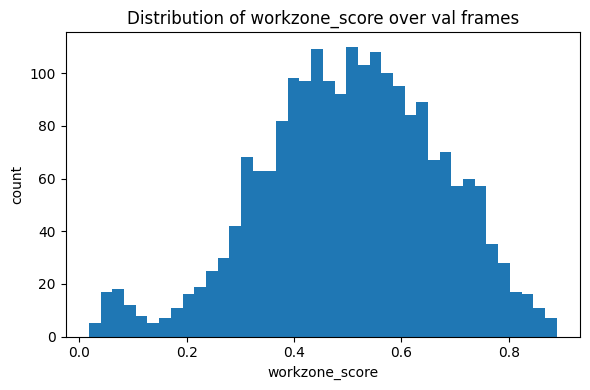

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(df["workzone_score"], bins=40)
plt.xlabel("workzone_score")
plt.ylabel("count")
plt.title("Distribution of workzone_score over val frames")
plt.tight_layout()
plt.show()

In [13]:
print(df["scene_label"].value_counts(dropna=False))

df.groupby("scene_label")["workzone_score"].describe()

scene_label
workzone_ahead    2041
lane_shift          56
NaN                  1
Name: count, dtype: int64


,count,mean,std,min,25%,50%,75%,max
scene_label,,,,,,,,
lane_shift,56.0,0.555125,0.175156,0.062080,0.481234,0.573428,0.682785,0.870348
workzone_ahead,2041.0,0.502919,0.166695,0.018219,0.394129,0.508494,0.622167,0.889129


In [14]:
# Save everything for later use (temporal notebook, Streamlit demo etc.)

MODELS_DIR.mkdir(parents=True, exist_ok=True)
df.to_csv(OUT_CSV, index=False)

print("Saved frame scores with workzone_score to:", OUT_CSV)

Saved frame scores with workzone_score to: models/workzone_frame_scores.csv
